In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
# from MakeSyntheticSeismic import MakeSeismic, PlotSeis,MakeSeismic_VN
from PlotSeis import PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf

In [4]:
# Generating images 
# num_img = 200
# clean_signal2, noise2, noisy_signal2 = MakeSeismic(samples=num_img,img_size=256,num_events=10)
# clean_signal_HF, noise_HF, noisy_signal_HF = MakeSeismic_VN(samples=num_img,img_size=256,num_events=10)

In [5]:
clean_signal_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/cs.npy')
noise_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/n.npy')
noisy_signal_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/ns.npy')



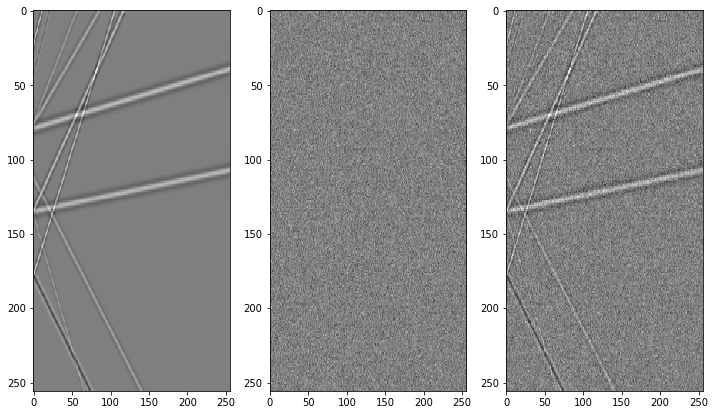

In [6]:
PlotSeis([clean_signal_HF,noise_HF,noisy_signal_HF],num=163)

In [7]:
psnr = []
num_img=600
for i in range(num_img):
    psnr.append(PSNR(clean_signal_HF[i],noisy_signal_HF[i]))
print(np.min(psnr),np.max(psnr))

11.064474551256712 33.46251626927184


In [8]:
# Generating training and testing data
# NS_train_wind, NS_test_wind, S_train_wind, S_test_wind = train_test_split(ns_windows,cs_windows, test_size=0.33, random_state = 21)
NS_train, NS_test, S_train, S_test = train_test_split(noisy_signal_HF,clean_signal_HF, test_size=0.33, random_state = 21)

# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv_sc,cs_windows_conv_sc, test_size=0.33, random_state = 21)
# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv,cs_windows_conv, test_size=0.33, random_state = 21)

In [36]:
# Splitting images into windows to pass through the autoencoder if we're using windows 
NS_train_conv = []
NS_test_conv= []
S_train_conv = []
S_test_conv = []

NS_train_conv_w64 = []
NS_test_conv_w64 = []
S_train_conv_w64 = []
S_test_conv_w64 = []

NS_train_conv_w128 = []
NS_test_conv_w128 = []
S_train_conv_w128 = []
S_test_conv_w128 = []

win_size = 32
win_size_64 = 64
win_size_128 = 128

for iImg in range(NS_train.shape[0]):
    NS_train_conv.append(img2windows(NS_train[iImg,:,:,0],win_size,win_size))
    S_train_conv.append(img2windows(S_train[iImg,:,:,0],win_size,win_size))
    NS_train_conv_w64.append(img2windows(NS_train[iImg,:,:,0],win_size_64,win_size_64))
    S_train_conv_w64.append(img2windows(S_train[iImg,:,:,0],win_size_64,win_size_64))
    NS_train_conv_w128.append(img2windows(NS_train[iImg,:,:,0],win_size_128,win_size_128))
    S_train_conv_w128.append(img2windows(S_train[iImg,:,:,0],win_size_128,win_size_128))
for iImg in range(NS_test.shape[0]):
    NS_test_conv.append(img2windows(NS_test[iImg,:,:,0],win_size,win_size))
    S_test_conv.append(img2windows(S_test[iImg,:,:,0],win_size,win_size))
    NS_test_conv_w64.append(img2windows(NS_test[iImg,:,:,0],win_size_64,win_size_64))
    S_test_conv_w64.append(img2windows(S_test[iImg,:,:,0],win_size_64,win_size_64))
    NS_test_conv_w128.append(img2windows(NS_test[iImg,:,:,0],win_size_128,win_size_128))
    S_test_conv_w128.append(img2windows(S_test[iImg,:,:,0],win_size_128,win_size_128))


NS_train_conv = np.array(NS_train_conv)
NS_test_conv = np.array(NS_test_conv)
S_train_conv = np.array(S_train_conv)
S_test_conv = np.array(S_test_conv)

NS_train_conv_w64 = np.array(NS_train_conv_w64)
NS_test_conv_w64 = np.array(NS_test_conv_w64)
S_train_conv_w64 = np.array(S_train_conv_w64)
S_test_conv_w64 = np.array(S_test_conv_w64)

NS_train_conv_w128 = np.array(NS_train_conv_w128)
NS_test_conv_w128 = np.array(NS_test_conv_w128)
S_train_conv_w128 = np.array(S_train_conv_w128)
S_test_conv_w128 = np.array(S_test_conv_w128)

In [37]:
# Splitting out the traces into a single continuous file
# NS_train_trc_resh = NS_train.reshape(NS_train.shape[0]*NS_train.shape[1],256)
# S_train_trc_resh = S_train.reshape(NS_train.shape[0]*NS_train.shape[1],256)
# NS_test_trc_resh = NS_test.reshape(NS_test.shape[0]*NS_test.shape[1],256)
# S_test_trc_resh = S_test.reshape(NS_test.shape[0]*NS_test.shape[1],256)

# Reshaping conv windows 
NS_train_conv_resh = NS_train_conv.reshape(NS_train_conv.shape[0]*NS_train_conv.shape[1],NS_train_conv.shape[2],NS_train_conv.shape[3],1)
S_train_conv_resh = S_train_conv.reshape(S_train_conv.shape[0]*S_train_conv.shape[1],S_train_conv.shape[2],S_train_conv.shape[3],1)
NS_test_conv_resh = NS_test_conv.reshape(NS_test_conv.shape[0]*NS_test_conv.shape[1],NS_test_conv.shape[2],NS_test_conv.shape[3],1)
S_test_conv_resh = S_test_conv.reshape(S_test_conv.shape[0]*S_test_conv.shape[1],S_test_conv.shape[2],S_test_conv.shape[3],1)

NS_train_conv_resh_w64 = NS_train_conv_w64.reshape(NS_train_conv_w64.shape[0]*NS_train_conv_w64.shape[1],NS_train_conv_w64.shape[2],NS_train_conv_w64.shape[3],1)
S_train_conv_resh_w64 = S_train_conv_w64.reshape(S_train_conv_w64.shape[0]*S_train_conv_w64.shape[1],S_train_conv_w64.shape[2],S_train_conv_w64.shape[3],1)
NS_test_conv_resh_w64 = NS_test_conv_w64.reshape(NS_test_conv_w64.shape[0]*NS_test_conv_w64.shape[1],NS_test_conv_w64.shape[2],NS_test_conv_w64.shape[3],1)
S_test_conv_resh_w64 = S_test_conv_w64.reshape(S_test_conv_w64.shape[0]*S_test_conv_w64.shape[1],S_test_conv_w64.shape[2],S_test_conv_w64.shape[3],1)

NS_train_conv_resh_w128 = NS_train_conv_w128.reshape(NS_train_conv_w128.shape[0]*NS_train_conv_w128.shape[1],NS_train_conv_w128.shape[2],NS_train_conv_w128.shape[3],1)
S_train_conv_resh_w128 = S_train_conv_w128.reshape(S_train_conv_w128.shape[0]*S_train_conv_w128.shape[1],S_train_conv_w128.shape[2],S_train_conv_w128.shape[3],1)
NS_test_conv_resh_w128 = NS_test_conv_w128.reshape(NS_test_conv_w128.shape[0]*NS_test_conv_w128.shape[1],NS_test_conv_w128.shape[2],NS_test_conv_w128.shape[3],1)
S_test_conv_resh_w128 = S_test_conv_w128.reshape(S_test_conv_w128.shape[0]*S_test_conv_w128.shape[1],S_test_conv_w128.shape[2],S_test_conv_w128.shape[3],1)

In [55]:
NS_train.shape

(402, 256, 256, 1)

In [58]:
# NS_train_trc_resh_ten = tf.convert_to_tensor(NS_train_trc_resh)
# NS_test_trc_resh_ten = tf.convert_to_tensor(NS_test_trc_resh)
# S_train_trc_resh_ten = tf.convert_to_tensor(S_train_trc_resh)
# S_test_trc_resh_ten = tf.convert_to_tensor(S_test_trc_resh)

NS_train_conv_resh_ten = tf.convert_to_tensor(NS_train_conv_resh)
NS_test_conv_resh_ten = tf.convert_to_tensor(NS_test_conv_resh)
S_train_conv_resh_ten = tf.convert_to_tensor(S_train_conv_resh)
S_test_conv_resh_ten = tf.convert_to_tensor(S_test_conv_resh)


NS_train_conv_resh_ten_w64 = tf.convert_to_tensor(NS_train_conv_resh_w64)
NS_test_conv_resh_ten_w64 = tf.convert_to_tensor(NS_test_conv_resh_w64)
S_train_conv_resh_ten_w64 = tf.convert_to_tensor(S_train_conv_resh_w64)
S_test_conv_resh_ten_w64 = tf.convert_to_tensor(S_test_conv_resh_w64)


NS_train_conv_resh_ten_w128 = tf.convert_to_tensor(NS_train_conv_resh_w128)
NS_test_conv_resh_ten_w128 = tf.convert_to_tensor(NS_test_conv_resh_w128)
S_train_conv_resh_ten_w128 = tf.convert_to_tensor(S_train_conv_resh_w128)
S_test_conv_resh_ten_w128 = tf.convert_to_tensor(S_test_conv_resh_w128)

NS_train_conv_resh_ten_w256 = tf.convert_to_tensor(NS_train.reshape(NS_train.shape[0],NS_train.shape[1],NS_train.shape[2],1))
NS_test_conv_resh_ten_w256 = tf.convert_to_tensor(NS_test.reshape(NS_test.shape[0],NS_test.shape[1],NS_test.shape[2],1))
S_train_conv_resh_ten_w256 = tf.convert_to_tensor(S_train.reshape(S_train.shape[0],S_train.shape[1],S_train.shape[2],1))
S_test_conv_resh_ten_w256 = tf.convert_to_tensor(S_test.reshape(S_test.shape[0],S_test.shape[1],S_test.shape[2],1))

In [59]:
# # Creating models

# # modelConv3x3 = autoencoder("upsc",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConv3x3_v2 = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConv3x3_SGD = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConv3x3_v2_HF = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))

# # modelConvUnet = autoencoder("Unet_NoSc",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConvUnet_v2 = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConvUnet_v3_SGD = autoencoder("Unet_NoSc_v3",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConvUnet_v2_SGD = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))

# modelANN_trc = autoencoder("ANN")

# ANN_trc = autoencoder("ANN")
Conv3x3 = autoencoder("upsc_v2",kernel=(3,3),input_size=(32,32,1))
Conv3x3_w64 = autoencoder("upsc_v2",kernel=(3,3),input_size=(64,64,1))
Conv3x3_w128 = autoencoder("upsc_v2",kernel=(3,3),input_size=(128,128,1))
Conv3x3_w256 = autoencoder("upsc_v2",kernel=(3,3),input_size=(256,256,1))

# Unet = autoencoder("Unet_v3",kernel=(3,3),input_size=(32,32,1))

In [60]:
# # Compiling models
# sgd = Adam(lr=0.001)
# # modelConv3x3.compile(loss='mse',optimizer='adam')
# # modelConv3x3_v2.compile(loss='mse',optimizer='adam')
# # modelConv3x3_SGD.compile(loss='mse',optimizer=sgd)
# modelConv3x3_v2_HF.compile(loss='mse',optimizer='adam')
# modelConv3x3_v2_dr_HF.compile(loss='mse',optimizer='adam')

# # modelConvUnet.compile(loss='mse',optimizer='adam')
# modelConvUnet_v2.compile(loss='mse',optimizer='adam')
# # modelConvUnet_v2_SGD.compile(loss='mse',optimizer=sgd)
# # modelConvUnet_v3_SGD.compile(loss='mse',optimizer=sgd)

# modelANN_trc.compile(loss='mse',optimizer='adam')
# # modelANN_trc_SGD.compile(loss='mse',optimizer=sgd)

# ANN_trc.compile(loss='mse',optimizer='adam')
Conv3x3.compile(loss='mse',optimizer='adam')
Conv3x3_w64.compile(loss='mse',optimizer='adam')
Conv3x3_w128.compile(loss='mse',optimizer='adam')
Conv3x3_w256.compile(loss='mse',optimizer='adam')

# Unet.compile(loss='mse',optimizer='adam')

In [61]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0005,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [62]:
batch_size= 32
epochs = 200
Conv3x3_hist = Conv3x3.fit( NS_train_conv_resh_ten, S_train_conv_resh_ten, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_ten,S_test_conv_resh_ten),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
804/804 [==============================] - 5s 6ms/step - loss: 0.0472 - val_loss: 0.0223
Epoch 2/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0204 - val_loss: 0.0196
Epoch 3/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 4/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0139 - val_loss: 0.0150
Epoch 5/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 6/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0116 - val_loss: 0.0128
Epoch 7/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0105 - val_loss: 0.0125
Epoch 8/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0100 - val_loss: 0.0124
Epoch 9/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 10/200
804/804 [==============================] - 4s 5ms/step - loss: 0.0088 - val_lo

In [63]:
batch_size= 32
epochs = 200
Conv3x3_w64_hist = Conv3x3_w64.fit( NS_train_conv_resh_ten_w64, S_train_conv_resh_ten_w64, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_ten_w64,S_test_conv_resh_ten_w64),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
201/201 [==============================] - 3s 14ms/step - loss: 0.0620 - val_loss: 0.0285
Epoch 2/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0251 - val_loss: 0.0207
Epoch 3/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0182 - val_loss: 0.0175
Epoch 4/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 5/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 6/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 7/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0110 - val_loss: 0.0134
Epoch 8/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 9/200
201/201 [==============================] - 3s 13ms/step - loss: 0.0097 - val_loss: 0.0120
Epoch 10/200
201/201 [==============================] - 3s 13ms/step - loss: 0.009

In [64]:
batch_size= 32
epochs = 200
Conv3x3_w128_hist = Conv3x3_w128.fit( NS_train_conv_resh_ten_w128, S_train_conv_resh_ten_w128, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_ten_w128,S_test_conv_resh_ten_w128),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
51/51 [==============================] - 3s 51ms/step - loss: 0.0752 - val_loss: 0.0608
Epoch 2/200
51/51 [==============================] - 2s 48ms/step - loss: 0.0544 - val_loss: 0.0388
Epoch 3/200
51/51 [==============================] - 2s 48ms/step - loss: 0.0353 - val_loss: 0.0302
Epoch 4/200
51/51 [==============================] - 2s 48ms/step - loss: 0.0279 - val_loss: 0.0250
Epoch 5/200
51/51 [==============================] - 2s 48ms/step - loss: 0.0242 - val_loss: 0.0214
Epoch 6/200
51/51 [==============================] - 2s 47ms/step - loss: 0.0204 - val_loss: 0.0193
Epoch 7/200
51/51 [==============================] - 2s 47ms/step - loss: 0.0182 - val_loss: 0.0175
Epoch 8/200
51/51 [==============================] - 2s 47ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 9/200
51/51 [==============================] - 2s 47ms/step - loss: 0.0142 - val_loss: 0.0159
Epoch 10/200
51/51 [==============================] - 2s 47ms/step - loss: 0.0144 - val_loss: 0.0143

In [65]:
batch_size= 32
epochs = 200
Conv3x3_w256_hist = Conv3x3_w256.fit( NS_train_conv_resh_ten_w256, S_train_conv_resh_ten_w256, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_ten_w256,S_test_conv_resh_ten_w256),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
13/13 [==============================] - 9s 406ms/step - loss: 0.0755 - val_loss: 0.0718
Epoch 2/200
13/13 [==============================] - 2s 183ms/step - loss: 0.0739 - val_loss: 0.0700
Epoch 3/200
13/13 [==============================] - 2s 180ms/step - loss: 0.0720 - val_loss: 0.0615
Epoch 4/200
13/13 [==============================] - 2s 181ms/step - loss: 0.0595 - val_loss: 0.0506
Epoch 5/200
13/13 [==============================] - 2s 182ms/step - loss: 0.0522 - val_loss: 0.0454
Epoch 6/200
13/13 [==============================] - 2s 183ms/step - loss: 0.0452 - val_loss: 0.0410
Epoch 7/200
13/13 [==============================] - 2s 182ms/step - loss: 0.0395 - val_loss: 0.0354
Epoch 8/200
13/13 [==============================] - 2s 181ms/step - loss: 0.0339 - val_loss: 0.0314
Epoch 9/200
13/13 [==============================] - 2s 183ms/step - loss: 0.0313 - val_loss: 0.0285
Epoch 10/200
13/13 [==============================] - 2s 182ms/step - loss: 0.0285 - val_lo

In [30]:
# batch_size= 128
# epochs = 200
# Unet_hist = Unet.fit( NS_train_conv_resh_ten, S_train_conv_resh_ten, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_ten,S_test_conv_resh_ten),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [31]:
# batch_size= 128
# epochs = 200
# ANN_trc_hist = ANN_trc.fit( NS_train_trc_resh_ten, S_train_trc_resh_ten, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_trc_resh_ten,S_test_trc_resh_ten),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [66]:
# _2 = 128 batch size ** best ** 
# _3 = 64 batch size 
# _4 = 128 batch size with new correct noise level input

# currently Conv3x3_v2 and ConvUnet_v3_SGD are my preferred 
# hists = pd.DataFrame(modelANN_trc_hist.history)
# hists["model"]="ANN_trc"
hists = pd.read_csv('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/perf/hists.csv')
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_hist.history),"ConvUpsc_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v2_hist.history),"ConvUpsc_v2_100img")

hists= store_hist(hists,pd.DataFrame(Conv3x3_hist.history),"Conv3x3_w32_ND")
hists= store_hist(hists,pd.DataFrame(Conv3x3_w64_hist.history),"Conv3x3_w64_ND")
hists= store_hist(hists,pd.DataFrame(Conv3x3_w128_hist.history),"Conv3x3_w128_ND")
hists= store_hist(hists,pd.DataFrame(Conv3x3_w256_hist.history),"Conv3x3_w256_ND")



# hists= store_hist(hists,pd.DataFrame(modelConvUnet_hist.history),"ConvUnet_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_hist.history),"ConvUnet_v2_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_SGD_hist.history),"ConvUnet_v2_SGD_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_SGD_hist.history),"ConvUpsc_SGD_100img")

# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_SGD_hist.history),"ConvUnet_v3_SGD_100img")

# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v3_hist.history),"ConvUpsc_v3_100img")

hists.to_csv('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/perf/hists.csv')


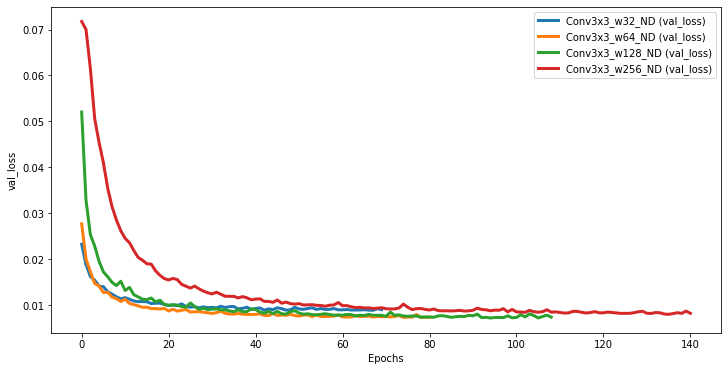

In [67]:
plot_perf(hists,['Conv3x3_w32_ND','Conv3x3_w64_ND','Conv3x3_w128_ND','Conv3x3_w256_ND'],['val_loss'])

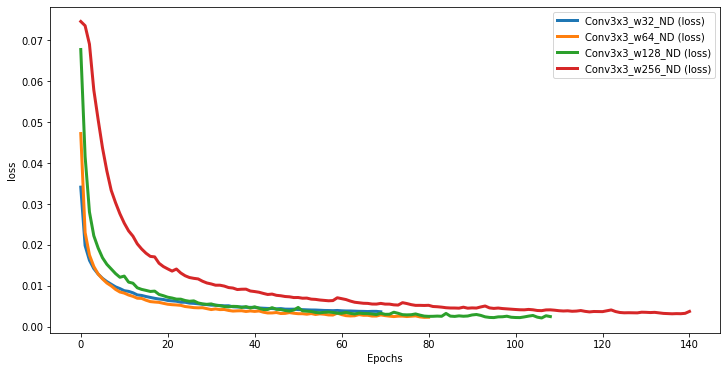

In [68]:
plot_perf(hists,['Conv3x3_w32_ND','Conv3x3_w64_ND','Conv3x3_w128_ND','Conv3x3_w256_ND'],['loss'])

In [31]:
#Saving Models

#v1 = orig
#v2 = smaller, removed one encoder and one decoder layer
# Currently prefer conv3x3_v2 and Unet_v2_SGD - Unet overfits on real data

# SGD = using lr = 0.001, converges slightly slower

# modelUnetMSE.save('./models/UnetMSE_16filt')
# modelUnetMSE.save('./models/UnetMSE_8filt')
# modelANN_wind.save('./models/ANN_wind_4')
# modelANN_trc.save('./models/ANN_trc_4')

# modelANN_trc_SGD.save('./models/ANN_trc_SGD_p')

# modelConv3x3.save('./models/UpscConv3x3')
# modelConv3x3_v2.save('./models/UpscConv3x3_v2')
# modelConv3x3_SGD.save('./models/UpscConv3x3_SGD')
# modelConv3x3_v2_HF.save('./models/UpscConv3x3_v2_HF')
# modelConv3x3_v2_dr_HF.save('./models/UpscConv3x3_v2_dr_HF')

# modelConvUnet.save('./models/Unet_v1')
# modelConvUnet_v2.save('./models/Unet_v2')
# modelConvUnet_v2_SGD.save('./models/Unet_v2_SGD')
# modelConvUnet_v3_SGD.save('./models/Unet_v3_SGD')

ANN_trc.save('./models/new_data/ANN')
Conv3x3.save('./models/new_data/Conv3x3')
Unet.save('./models/new_data/Unet')

INFO:tensorflow:Assets written to: ./models/new_data/ANN/assets
INFO:tensorflow:Assets written to: ./models/new_data/Conv3x3/assets
INFO:tensorflow:Assets written to: ./models/new_data/Unet/assets


In [32]:
# from tensorflow.keras.models import load_model
# modelANN_trc = load_model('./models/ANN_trc_4')
# modelANN_wind = load_model('./models/ANN_wind_4')
# modelConv3x3_v1 = load_model('./models/UpscConv3x3_v2/')
# modelConv3x3 = load_model('./models/UpscConv3x3')
# modelConv3x3_v2 = load_model('./models/UpscConv3x3_v2')
# modelConv3x3_SGD = load_model('./models/UpscConv3x3_SGD')
# modelConvUnet = load_model('./models/Unet_v1')
# modelConvUnet_v2 = load_model('./models/Unet_v2')
# modelConvUnet_v2_SGD = load_model('./models/Unet_v2_SGD')
# modelConv3x3_v2_HF = load_model('./models/UpscConv3x3_v2_HF')
# modelConv3x3_v2_dr_HF = load_model('./models/UpscConv3x3_v2_dr_HF')

In [33]:
def pred_resh(data,output_size,num_wind,wind_size):

    # Reshaping predictions
    data_resh= data.reshape(int(data.shape[0]/num_wind),num_wind,wind_size,wind_size)

    img = []

    for iImg in range(data_resh.shape[0]):
        img.append(windows2img(data_resh[iImg],output_size,output_size))

    img = np.array(img)


    return img

In [34]:
# Predicting

# pred = modelUnet.predict(NS_test)
# pred2 = modelUnet.predict(ns_test)
# predmse = modelUnetMSE.predict(NS_test_nosc)
# predmse3 = modelUnetMSE.predict(NS_test_nosc)

# pred_upsc = modelUpSc.predict(ns_test)
# pred_nosc = modelUnetNoSc.predict(NS_test_nosc)

# predANN_trc = modelANN_trc_v1.predict(NS_test_trc_resh)
# predANN_trc = modelANN_trc.predict(NS_test_trc_resh)
# predANN_trc_SGD = modelANN_trc_SGD.predict(NS_test_trc_resh)


# predANN_wind_v1 = modelANN_wind_v1.predict(NS_test_wind_resh)
# predANN_wind = modelANN_wind.predict(NS_test_wind_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_4x4 = modelConv4x4.predict(NS_test_conv_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2 = modelConv3x3_v2.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2_HF = modelConv3x3_v2_HF.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2_dr_HF = modelConv3x3_v2_dr_HF.predict(NS_test_conv_resh)

# predConvUnet = modelConvUnet.predict(NS_test_conv_resh)
# predConvUnet_v2 = modelConvUnet_v2.predict(NS_test_conv_resh)
# predConvUnet_v2_SGD = modelConvUnet_v2_SGD.predict(NS_test_conv_resh)
# predConvUnet_v3_SGD = modelConvUnet_v3_SGD.predict(NS_test_conv_resh)

predANN_trc = ANN_trc.predict(NS_test_trc_resh).reshape(NS_test.shape)
predConv3x3 = Conv3x3.predict(NS_test_conv_resh)
predUnet = Unet.predict(NS_test_conv_resh)

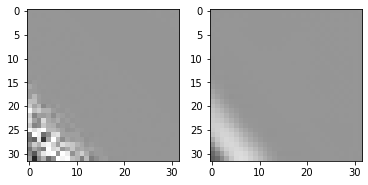

In [40]:
num = 12
plt.subplot(1,2,1)
plt.imshow(NS_test_conv_resh[num].reshape(win_size,win_size),cmap='Greys',vmin=-2,vmax=2)
plt.subplot(1,2,2)
plt.imshow(predUnet[num].reshape(win_size,win_size),cmap='Greys',vmin=-2,vmax=2)

In [41]:
# decodedimg_conv3x3 = pred_resh(predConv_wind_3x3,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2 = pred_resh(predConv_wind_3x3_v2,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2_HF = pred_resh(predConv_wind_3x3_v2_HF,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2_dr_HF = pred_resh(predConv_wind_3x3_v2_dr_HF,output_size=256,num_wind=64,wind_size=32)


# decodedimg_convUnet = pred_resh(predConvUnet,output_size=256,num_wind=64,wind_size=32)
# decodedimg_convUnet_v2 = pred_resh(predConvUnet_v2,output_size=256,num_wind=64,wind_size=32)
# decodedimg_convUnet_v2_SGD = pred_resh(predConvUnet_v2_SGD,output_size=256,num_wind=64,wind_size=32)

# decodedimg_convUnet_v3_SGD = pred_resh(predConvUnet_v3_SGD,output_size=256,num_wind=64,wind_size=32)

predConv3x3_img = pred_resh(predConv3x3,output_size=256,num_wind=64,wind_size=32)
predUnet_img = pred_resh(predUnet,output_size=256,num_wind=64,wind_size=32)

# decodedimg_ANNwind = pred_resh(predANN_wind,output_size=256,num_wind=256,wind_size=16)

In [44]:
# Reshaping predictions
orig_noisy = []
orig_clean = []
for iImg in range(198):
    orig_noisy.append(windows2img(NS_test_conv[iImg],256,256))
    orig_clean.append(windows2img(S_test_conv[iImg],256,256))

orig_noisy = np.array(orig_noisy)
orig_clean = np.array(orig_clean)

<Figure size 1080x720 with 0 Axes>

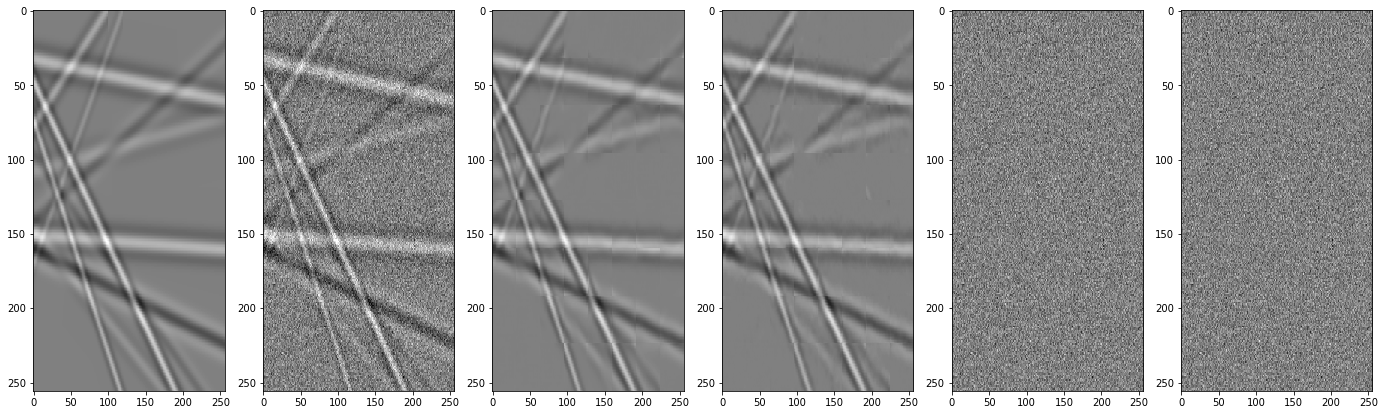

In [50]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean,orig_noisy,predConv3x3_img,predUnet_img,orig_noisy-predConv3x3_img,orig_noisy-predUnet_img],num=5)